In [1]:
import os
import sys
import traceback
import numpy as np
from os.path import join
import pandas as pd
from tqdm import tqdm_notebook
from tqdm import tqdm
import gc; gc.enable() # memory is tight
from IPython.display import clear_output
import matplotlib.pyplot as plt
import datetime

import torch
import torchvision
import torch.nn as nn
from torch import sigmoid
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader
torch.backends.cudnn.benchmark=True

%load_ext autoreload
%autoreload 2
sys.path.append("../../")
from src import utils
from src import ourmodels
from src.main import DeepLearning



USE_CUDA= False

DATA = "../../data/"

MODEL_CHECKPOINT = join("./")
TRAINED_NET = join(MODEL_CHECKPOINT, 'model.pt')

SHIP_DIR = "/media/shivam/DATA/airbus-tracking/"
TRAIN_IMAGE_DIR = os.path.join(SHIP_DIR, "train_v2")
TEST_IMAGE_DIR = os.path.join(SHIP_DIR, "test_v2")

CSV_TRAIN = join(DATA, 'balanced_train_df_shipgt_4.csv')
CSV_VALID = join(DATA, 'balanced_valid_df_shipgt_4.csv')


TRAIN_BATCH = 1
VALID_BATCH = 1
TEST_BATCH = 1

# Dataset and preprocessing

In [10]:
class KaggleDataset(Dataset):
    def __init__(self, datapath, phase):
        self.data = pd.read_csv(datapath)
        self.phase = phase
        self.image_ids = np.unique(self.data['ImageId'])
        print("Unique images: {}".format(len(self.image_ids)))
            
    def __len__(self):
        return len(self.image_ids)
    
    
    def __getitem__(self, idx):
        rgb_path = os.path.join(TRAIN_IMAGE_DIR, self.image_ids[idx])
        c_img = plt.imread(rgb_path)
        c_mask = utils.masks_as_image(self.data[self.data['ImageId'] == self.image_ids[idx]]['EncodedPixels'].tolist())
        
        c_img = np.stack(c_img, 0)/255.0
        c_mask = np.stack(c_mask, 0)
        if self.phase == 'train':
            crop_delta = 256
            factor = 5
            h, w, _ = c_mask.shape
            # Random crop selection trick
            x1 = np.random.randint(0, h-crop_delta)
            x2 = np.random.randint(0, w-crop_delta)
            c_mask = c_mask[x1:x1+crop_delta, x2:x2+crop_delta, :]
            c_img = c_img[x1:x1+crop_delta, x2:x2+crop_delta, :]
        
        c_img = c_img.transpose(-1, 0, 1)
        c_mask = c_mask.transpose(-1, 0, 1)
        return c_img.astype('f'), c_mask.astype('f')
    
    def convertScoreMapToImg(self, X, y_pred, figname):
        x_tmp = X.transpose(-1, 1, 0)
        y_pred = y_pred.transpose(-1, 1, 0)[:, :, 0]
        
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0

        utils.save_im(x_tmp, y_pred, "Original image", "Prediction", figname)
 

#     def item_as_image(self, items):
#         b = items.shape[0] if items.shape[0] > 0 else 1
#         for 
#         y_pred_tmp = y_pred[b, :, :, :].cpu().numpy().transpose(-1, 1, 0)[:, :, 0]

#         x_tmp = x[b, :, :, :].numpy().transpose(-1, 1, 0)

class Kaggle_Dataset_Test(Dataset):
    def __init__(self, testdir):
        self.testdir = testdir
        self.test_images = os.listdir(testdir)
        
    def __len__(self):
        return len(self.test_images)
    
    def __getitem__(self, idx):
        rgb_path = os.path.join(self.testdir, self.test_images[idx])
        c_img = plt.imread(rgb_path)
        c_img = np.stack(c_img, 0)/255.0
        c_img = c_img.transpose(-1, 0, 1)
        return self.test_images[idx], c_img.astype('f')
    
    def item_to_encoding(self, y_name, y_pred):
        y_pred = y_pred.transpose(-1, 1, 0)
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0

        cur_rles = utils.multi_rle_encode(y_pred)
        out_pred_rows = []
        if len(cur_rles)>0:
            for c_rle in cur_rles:
                out_pred_rows += [{'ImageId': y_name, 'EncodedPixels': c_rle}]
        else:
            out_pred_rows += [{'ImageId': y_name, 'EncodedPixels': None}]
        return out_pred_rows

# Initializing for training

In [11]:
# Load in Dataset
trainDataset = KaggleDataset(CSV_TRAIN, 'train')
validDataset = KaggleDataset(CSV_VALID, 'valid')
testDataset = Kaggle_Dataset_Test(TEST_IMAGE_DIR)

Unique images: 4740
Unique images: 48


(3, 256, 256) (1, 256, 256)


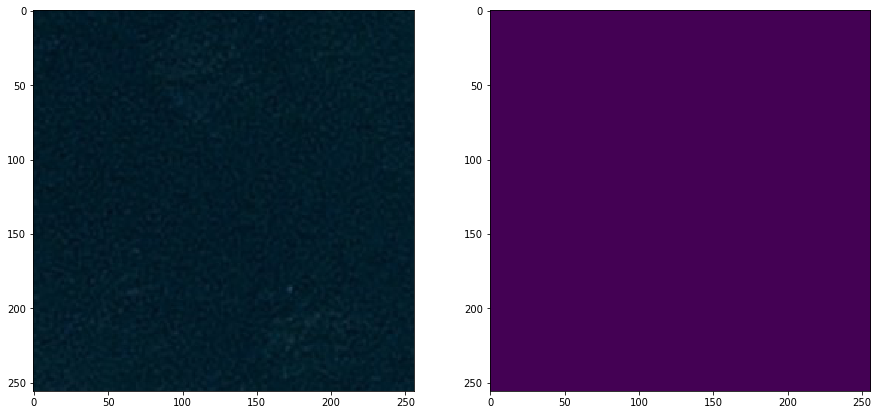

In [12]:
e = trainDataset[105]
utils.show(e[0], e[1])

# Training

Epoch: 1, running loss: 0.0004, validation loss: 0.0433


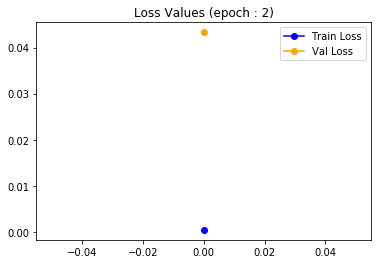

Training in epoch: 2


Starting validation...


Process Process-1:
Traceback (most recent call last):
  File "/home/shivam/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shivam/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shivam/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/shivam/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/shivam/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/shivam/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/shivam/anaconda3/envs/fastai/lib/python3.6/multiprocessin

KeyboardInterrupt: 

In [7]:
# Construct UNet
gc.collect()
reuse = False

net = ourmodels.UNet(3, 1)
criterion = nn.BCELoss()

# Load trained model if specified
if reuse:
    print("Reusing model from: {}".format(TRAINED_UNET_MODEL))
    net.load_state_dict(torch.load(TRAINED_UNET_MODEL))
    net.eval()
    
model = DeepLearning(net, MODEL_CHECKPOINT, cuda=USE_CUDA)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Initialize train dataloader
trainDataLoader   = torch.utils.data.DataLoader(
        trainDataset
        , batch_size=TRAIN_BATCH,shuffle=True
        , num_workers=1, pin_memory=True)

# Initialize validation dataloader
validDataLoader   = torch.utils.data.DataLoader(
        validDataset
        , batch_size=VALID_BATCH,shuffle=False
        , num_workers=0, pin_memory=True)


model.fit(trainDataLoader, 10, optimizer, criterion, validDataLoader)

# Inference

In [13]:
#Load testing images
testDataLoader   = torch.utils.data.DataLoader(
        testDataset
        , batch_size=TEST_BATCH,shuffle=False
        , num_workers=4, pin_memory=True)
print("Number of test images found: {}".format(len(testDataLoader)))

# Load inference model
# net = ourmodels.UNet(3, 1).cuda()
net = ourmodels.UNet(3, 1)
model = DeepLearning(net, MODEL_CHECKPOINT, cuda=USE_CUDA)

Number of test images found: 15606


In [14]:
out_pred_rows = model.predict(testDataLoader)

In [16]:
# Save dataframe to submission file.
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission_{}.csv'.format(str(datetime.datetime.now())), index=False)
submission_df.sample(3)

,ImageId,EncodedPixels
4,0008ca6e9.jpg,None
3,000367c13.jpg,149384 1 150151 2 150919 1
5,000a4635f.jpg,None
